In [1]:
import sys
sys.path.append('../Codes/')
import numpy as np
import matplotlib.pyplot as plt
from Immuno_models import*
from Bio import Phylo
from io import StringIO
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
import scipy.special as sc
import os.path
import pickle
from matplotlib import style
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from IPython.display import display, Math

def my_linear_func(x, a, b):
    return a + b*x
def my_quadratic_func(x, a, b, c):
    return np.log(a)+np.log(np.sqrt(-b)) + b*(x-c)**2

N_A = 6.02214076e23
k_BT = 1.380649e-23*293
style.use('seaborn-paper')
print(style.available)
%autosave 60

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


Autosaving every 60 seconds


In [2]:
%%time
n_seq = 500000

#Sequences = generate_Sequences(n_seq, Energy_Matrix = )
#pickle.dump( Sequences, open( "../Text_files/Sequences-n_seq-%d.pkl"%(n_seq), "wb" ) )

Sequences = pickle.load( open( "../Text_files/Sequences_MJ2-n_seq-%d.pkl"%(n_seq), "rb" ) )

CPU times: user 4.19 s, sys: 303 ms, total: 4.5 s
Wall time: 4.51 s


(-40.03, -35.03)

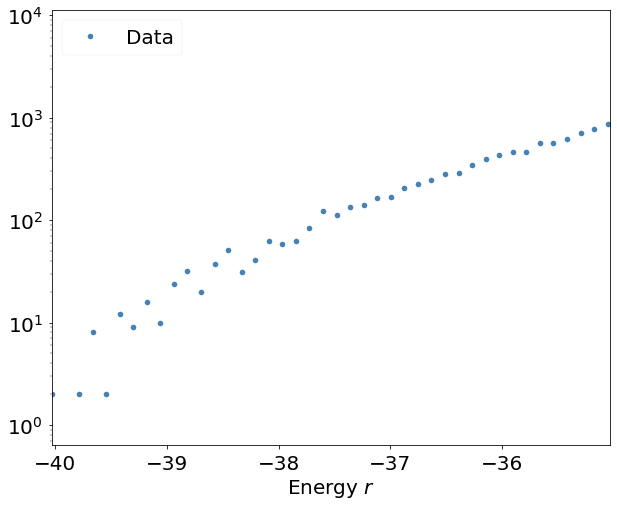

In [3]:
#___________________________________________
fig, ax = plt.subplots(1,1,figsize=(10,8))
distances = plot_histogram_hamming_distance(Sequences = Sequences, ax = ax)
plt.close()
#___________________________________________
fig, ax = plt.subplots(1,1,figsize=(10,8))
energies, data_energies = plot_histogram_energy(Sequences = Sequences, bins = 'auto', ax = ax)
ax.set_xlim(np.min(energies),np.min(energies)+5 )


In [4]:
%%time
#Left_tail = np.array([Sequences[i] for i in range(int(len(Sequences))) if (Sequences[i].energy < np.min(energies)+4) ])
#pickle.dump( Left_tail, open( "../Text_files/Sequences_MJ2_left_tail-n_seq-%d.pkl"%(int(n_seq)), "wb" ) )
Left_tail = pickle.load(open( "../Text_files/Sequences_MJ2_left_tail-n_seq-%d.pkl"%(int(n_seq)), "rb" ) )

CPU times: user 20.2 ms, sys: 3.48 ms, total: 23.7 ms
Wall time: 25.4 ms


In [5]:
%%time
#____________ Create sub_energies (uncomment when kernel is restarted)
n_linages = 200
sub_energies = np.array([])
for i in range(1000):
    Sub_Sequences = np.random.choice(Sequences, n_linages)
    sub_energies = np.append(sub_energies,np.array([i.energy for i in Sub_Sequences]))

CPU times: user 421 ms, sys: 188 ms, total: 609 ms
Wall time: 610 ms


51.864097479582654 1.259335478761019


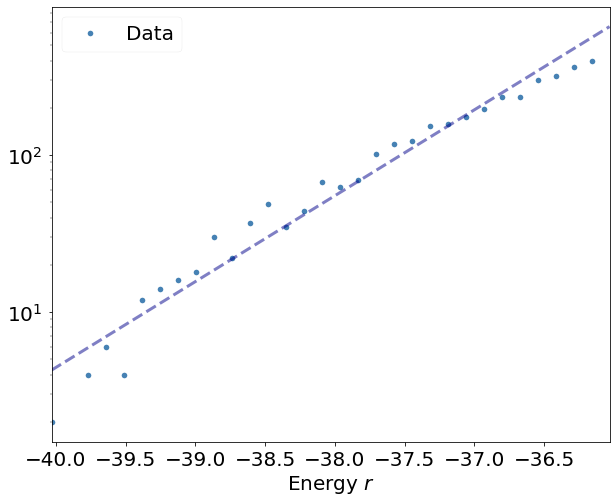

In [6]:
#___________________________________________
fig, ax = plt.subplots(1,1,figsize=(10,8))
distances_left_tail = plot_histogram_hamming_distance(Sequences = Left_tail, ax = ax)
plt.close()
#___________________________________________
fig, ax = plt.subplots(1,1,figsize=(10,8))
energies_left_tail, data_energies_left_tail = plot_histogram_energy(Sequences = Left_tail, bins = 'auto' , ax = ax)
ax.set_xlim(np.min(energies),np.min(energies)+4 )

popt, pcov = curve_fit(my_linear_func, data_energies_left_tail[1][0:-1][np.where(data_energies_left_tail[0]!=0)], np.log(data_energies_left_tail[0][np.where(data_energies_left_tail[0]!=0)]))
e_new = np.linspace(np.min(energies),np.min(energies)+4,100)
ax.plot(e_new, np.exp(my_linear_func(e_new, *popt)), linestyle  = 'dashed', linewidth = 3, color = 'darkblue', alpha = .5)
print(*popt)


In [7]:
#___________________________________________
fig, ax = plt.subplots(1,1, figsize = (10, 8))
plot_scatter_hamming_distance_energy(distances = distances, energies = energies, color = 'steelblue', ax = ax)
plot_scatter_hamming_distance_energy(distances = distances_left_tail, energies = energies_left_tail, color = 'olive', ax = ax)
fig.savefig('../Figures/Scatter_sequences_left_tail.png')


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fa6b8d86710> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fa6b8e11e60> (for post_execute):


KeyboardInterrupt: 

## One run

CPU times: user 22.9 s, sys: 166 ms, total: 23.1 s
Wall time: 23.1 s


(1.6605390671738466e-24, 2.2264845695831734e-08)

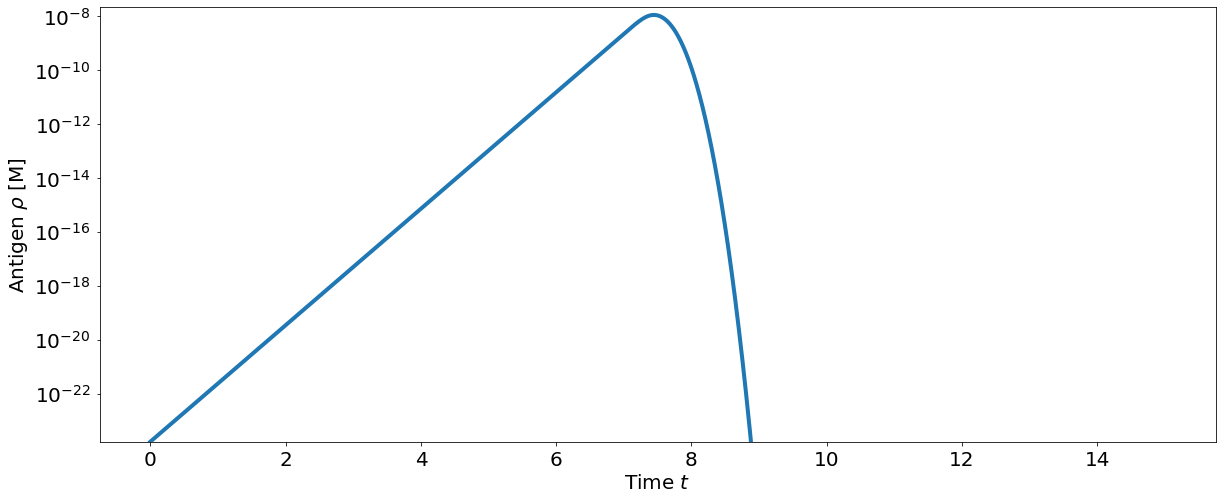

In [9]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = .5
beta = 5
gamma = 3
T = 15
energy_translation = 20
initial_time = 0
dt = 0.002
Sub_Sequences = np.random.choice(Left_tail, n_linages)
for i in range(n_linages):
    Sub_Sequences[i].active = False
Model  = Deterministic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T,
                                  U = U, nu = nu, beta = beta, gamma = gamma,
                                  energy_translation = energy_translation,
                                  initial_time = initial_time, dt = dt)
Model.ODE()

fig, ax = plt.subplots(1,1,figsize=(20,8))
Model.plot_antigen_time(ax = ax)
ax.set_ylim(np.exp(Model.beta*initial_time)/N_A, (np.max(Model.antigen_time_series)/N_A)*2)


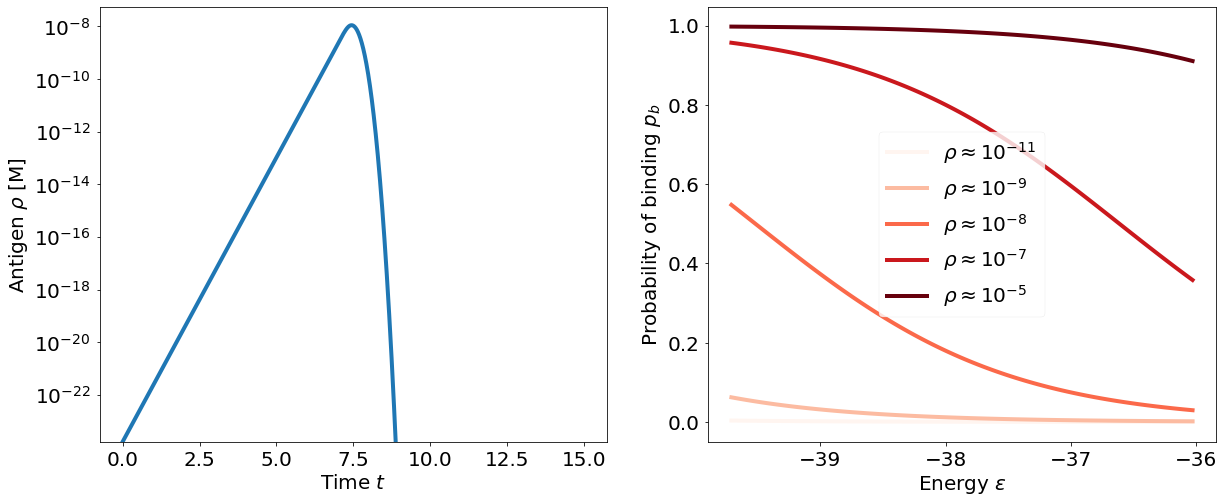

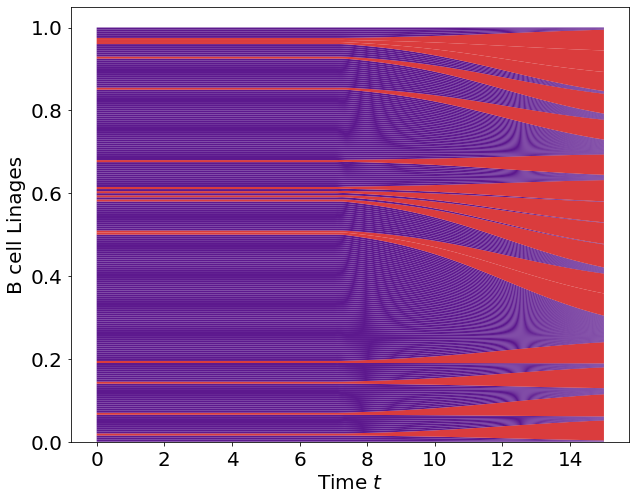

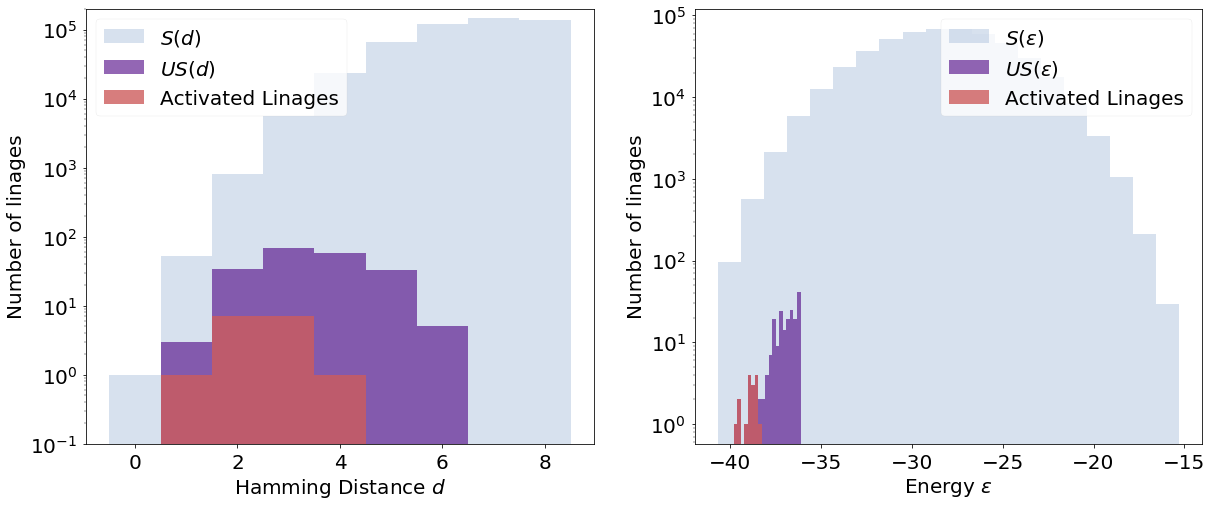

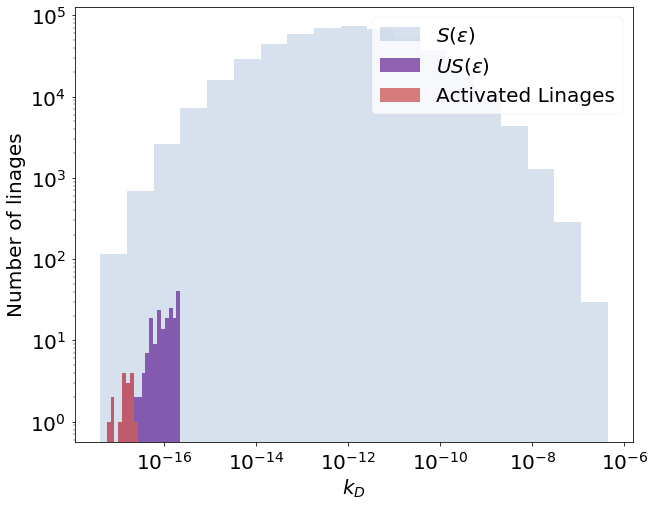

In [10]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
Model.plot_antigen_time(ax = ax[0])
Model.plot_prob_binding(ax = ax[1])
ax[1].set_yscale('linear')
counter = 0
while(os.path.isfile('../Figures/Antigen_Binding_%d.png'%(counter))):
    counter+=1
#fig.savefig('../Figures/Antigen_Binding_%d.png'%(0))
#--------------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(1,1,figsize=(10,8))
Model.stackplot_linages_time(antigen = False, time = True, ax = ax)
counter = 0
while(os.path.isfile('../Figures/Linages_%d.png'%(counter))):
    counter+=1
#fig.savefig('../Figures/Linages_%d.png'%(0))
#--------------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(1,2,figsize=(20,8))
Model.hist_sequences_hamming_distance(Sequences = Sequences, ax = ax[0])
Model.hist_sequences_energy(Sequences = Sequences, n_bins = 20, ax = ax[1])
counter = 0
while(os.path.isfile('../Figures/Histograms_hamming_energy_%d.png'%(counter))):
    counter+=1
#fig.savefig('../Figures/Histograms_hamming_energy_%d.png'%(0))
#--------------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(1,1,figsize=(10,8))
Model.hist_sequences_k_D(Sequences = Sequences, n_bins = 20, ax = ax)
ax.set_xscale('log')
ax.set_xlabel(r'$k_D$', fontsize = 20)
counter = 0
while(os.path.isfile('../Figures/Histogram_k_D_%d.png'%(counter))):
    counter+=1
#fig.savefig('../Figures/Histogram_k_D_%d.png'%(0))



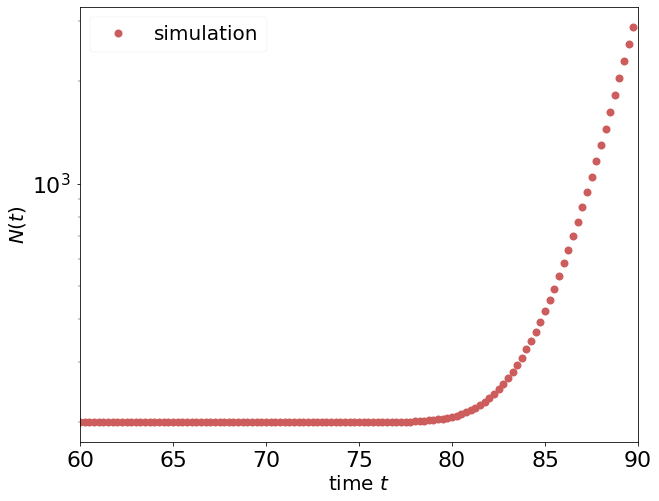

In [11]:
popt = np.array([ 1.35847161e+05, -4.92212036e-02, -2.79453873e+01])

fig, ax = plt.subplots(1,1,figsize=(10,8))
t_new = np.linspace(0, T, int(T/dt))
N_total = np.array([np.cumsum(np.exp(t-np.linspace(0,t, 100))*(1.7e2/5e5)*np.exp(my_quadratic_func(np.log(np.exp(np.linspace(0,t, 100))/N_A), *popt))*(t/100))[-1] + 200 - np.cumsum((2e2/5e5)*np.exp(my_quadratic_func(np.log(np.exp(np.linspace(0,t, 100))/N_A), *popt))*(t/100))[-1] for t in t_new])
#ax.plot(t_new, N_total, linestyle = '--', linewidth = 4, color = 'indianred', alpha = 0.4, label = 'gaussian model')
ax.plot(Model.time_series[::50], np.sum(Model.linages_time_series, axis=0)[::50], marker = 'o', ms = 8, color = 'indianred', linestyle = '', label = 'simulation')
ax.set_xlabel(r'time $t$', fontsize = 20)
ax.set_ylabel(r'$N(t)$', fontsize = 20)
ax.tick_params(labelsize = 22)
ax.set_yscale('log')
ax.set_xlim(2*T/3, T)
ax.legend(loc = 0, fontsize = 20)
counter = 0
while(os.path.isfile('../Figures/N_total_%d.png'%(counter))):
    counter+=1
#fig.savefig('../Figures/N_total_%d.png'%(0))


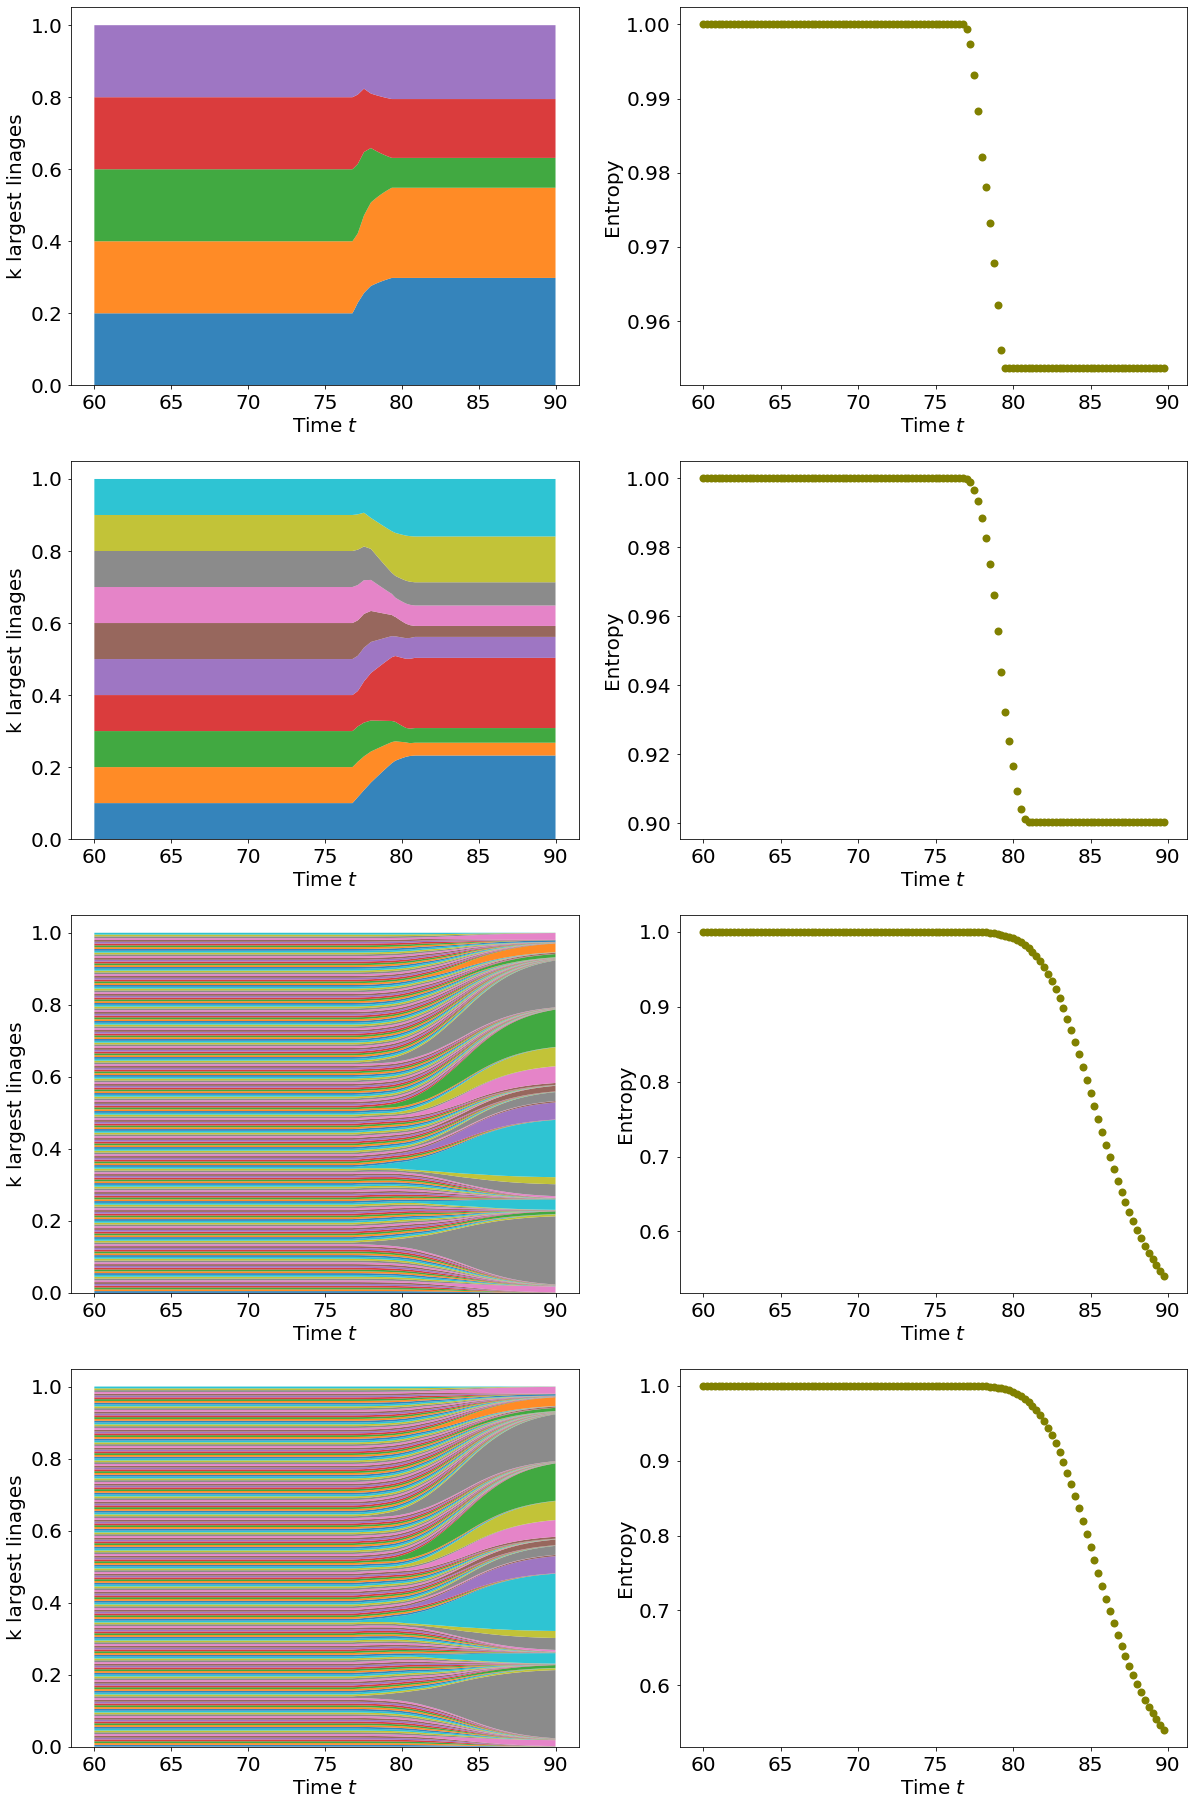

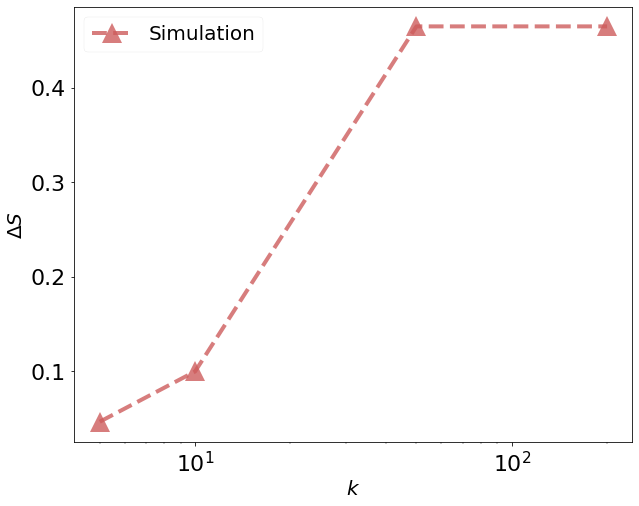

In [25]:
fig1, ax1 = plt.subplots(4,2,figsize=(20,32))
fig2, ax2 = plt.subplots(1,1,figsize=(10,8))
k_array = np.array([0, 5, 10, 50, 200])
Model.plot_entropy_drop(k_array = k_array, ax1 = ax1, ax2 = ax2)

counter = 0
while(os.path.isfile('../Figures/Muller_plots_entropy_%d.png'%(counter))):
    counter+=1
#fig1.savefig('../Figures/Muller_plots_entropy_%d.png'%(0))

counter = 0
while(os.path.isfile('../Figures/Entropy_drop_%d.png'%(counter))):
    counter+=1
#fig2.savefig('../Figures/Entropy_drop_%d.png'%(0))


## Ensemble

In [31]:
%%time
T = 90
dt = 0.01
run_ensemble_deterministic_model(Sequences = Left_tail, n_linages = 200, n_seq = 500000, nu = 1, beta = .2, T = T, 
                                 master_Sequence_energy = 0, initial_time = 60, dt = dt, n_sim = 200,
                                 comment = 'left_tail', new = False)


0 ...
40 ...
80 ...
120 ...
160 ...
Ensemble size: 28549
CPU times: user 10min 23s, sys: 2.07 s, total: 10min 25s
Wall time: 33min 7s


integral a*$\pi$: 426776.44387101685


<IPython.core.display.Math object>

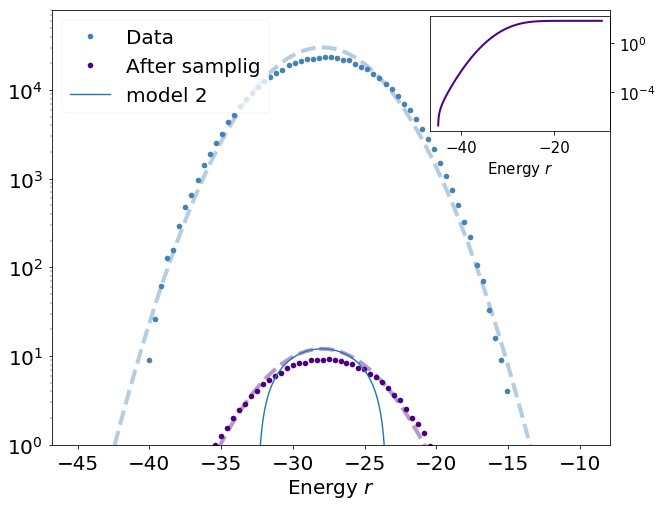

In [14]:
fig, ax = plt.subplots(1,1, figsize = (10, 8))
bins = 60
n_linages = 200
popt, pcov = plot_histogram_energy_subsampling(bins = bins, n_linages = n_linages, 
                                               Sequences = Sequences, sub_energies = sub_energies, fig = fig, ax = ax)
display(Math(r'y = %.3f e^{%.3f(\epsilon%.1f)^2}'%((popt[0]), popt[1], popt[2])))


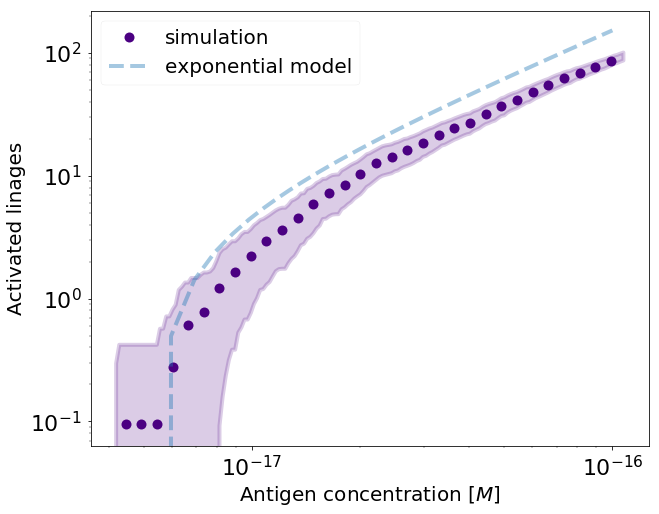

In [17]:
T = 90
dt = 0.01
beta = 0.2
to = 75
b = 1.26
initial_time = 60
fig, ax = plt.subplots(1, 1, figsize = (10,8))
plot_activation_rate_ensemble_deterministic(beta= beta, T = T, initial_time = initial_time, to=to, dt = dt, popt = popt, energies = energies, comment = 'left_tail', gaussian = False, exponential = True, ax = ax)


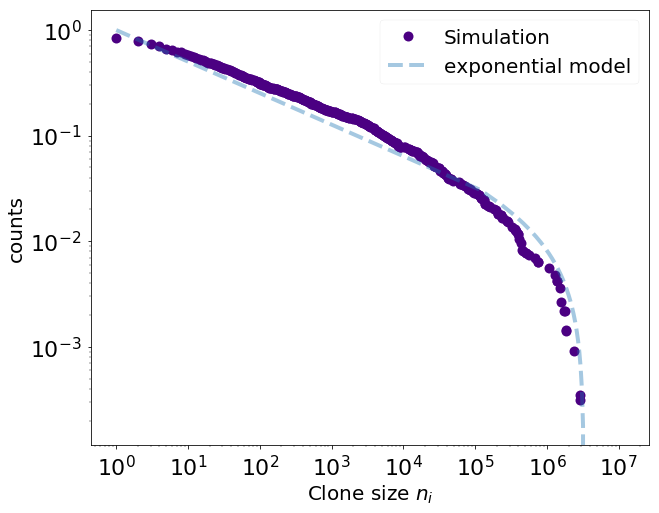

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
n_bins = 20
plot_size_distribution_ensemble_deterministic(T = T, to = to, dt = dt, n_bins = n_bins, density = True, popt = popt,
                                              comment = 'left_tail', gaussian = False, exponential = True, ax = ax)


(60, 90)

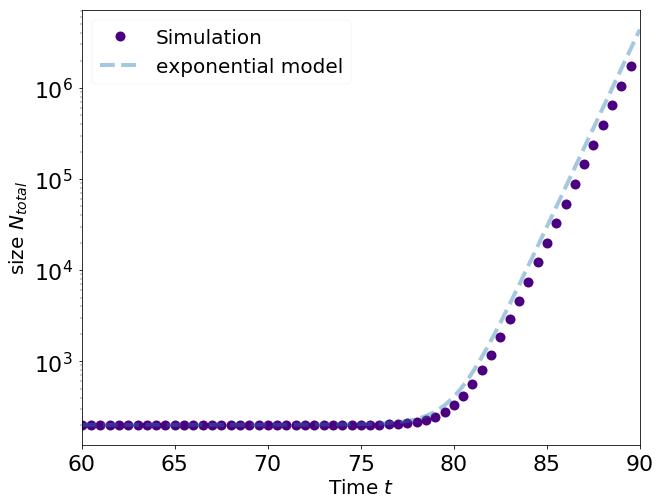

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
plot_N_total_ensemble_deterministic(T = T, initial_time = initial_time, to = 75, dt = 0.01, popt = popt, comment = 'left_tail',
                                    gaussian = False, exponential = True, ax = ax)
ax.set_xlim(initial_time, T)

#fig.savefig('../Figures/N_total_ensemble.png')


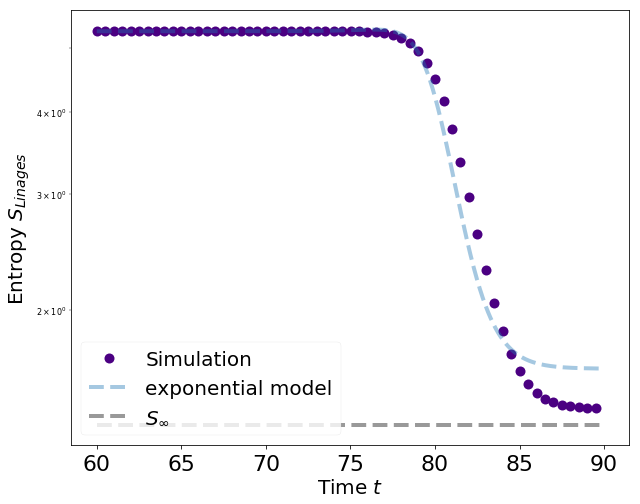

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
plot_entropy_ensemble_deterministic(T = T, initial_time = initial_time, to = 75, dt = 0.01, popt = popt, comment = 'left_tail',
                                    gaussian = False, exponential = True, ax = ax)
#fig.savefig('../Figures/Entropy_ensemble.png')


In [12]:
(1e5/N_A)*1e3

1.6605390671738467e-16